In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Read data from 2021 to 2023

In [83]:
df_2021 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2021/survey_results_public.csv')
df_2022 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2022/survey_results_public.csv')
df_2023 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2023/survey_results_public.csv')

### Merge data

In [84]:
def merge_and_extract_cols(df_2021, df_2022, df_2023):
    cols_to_extract = ['MainBranch', 'Age', 'Employment', 'EdLevel', 'LearnCode','YearsCodePro',
               'DevType', 'OrgSize', 'Country', 'Currency', 'CompTotal','CompFreq']
    extracted_C = df_2021[cols_to_extract]
    extracted_D = df_2022[cols_to_extract]
    extracted_E = df_2023[cols_to_extract]
    
    merged_data = pd.concat([extracted_C, extracted_D, extracted_E], ignore_index=True)
    merged_data = merged_data[merged_data['Employment'].isin(['Employed, full-time', 'Employed full-time'])]
    return merged_data

df_2023['CompFreq'] = 'Yearly'
merged_data = merge_and_extract_cols(df_2021, df_2022, df_2023)
print(merged_data.shape[0], merged_data.shape[1])

150294 12


### Extract job type related data science

In [85]:
merged_data['DevType'] = merged_data['DevType'].apply(lambda x: 'DS/MLE' 
                                                      if 'Data scientist or machine learning specialist' in str(x) 
                                                      else ('DE/DA/BA' if 'Data or business analyst' in str(x)
                                                      else ('DE/DA/BA' if 'Engineer, data' in str(x) else x)))

data_df = merged_data[merged_data['DevType'].isin(['DS/MLE', 'DE/DA/BA'])]
data_df['DevType'].value_counts()

DE/DA/BA    8940
DS/MLE      6716
Name: DevType, dtype: int64

### Extract education level

In [86]:
EdLevel_dict = {
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master',
    'Other doctoral degree (Ph.D., Ed.D., etc.)': 'Doctoral(PhD)',
    'Professional degree (JD, MD, Ph.D, Ed.D., etc.)': 'Doctoral(PhD)'
}

data_df.loc[:, 'EdLevel'] = data_df['EdLevel'].replace(EdLevel_dict)

data_df = data_df[data_df['EdLevel'].isin(['Bachelor', 'Master', 'Doctoral(PhD)'])]
data_df['EdLevel'].value_counts()

Bachelor         5970
Master           5832
Doctoral(PhD)    1299
Name: EdLevel, dtype: int64

### Normalize salary unit and range

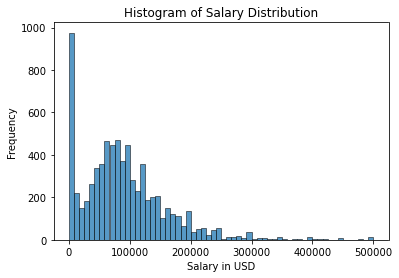

In [87]:
exchange_rates = {
    'USD': 1,
    'EUR': 1.18,
    'GBP': 1.38,
    'INR': 0.014,
    'CAD': 0.79,
    'AUD': 0.74
}

def convert_to_yearly(salary, unit):
    if unit == 'Yearly':
        return salary
    elif unit == 'Weekly':
        return salary * 52  
    elif unit == 'Hourly':
        return salary * 2080  
    else:
        return salary

data_df = data_df[data_df['Currency'].isin(['USD\tUnited States dollar', 
                                            'EUR European Euro', 
                                            'GBP\tPound sterling',
                                           'INR\tIndian rupee',
                                           'CAD\tCanadian dollar',
                                           'AUD\tAustralian dollar'])]

data_df['Currency_in_USD'] = data_df['Currency'].apply(lambda currency: exchange_rates[currency.split()[0]])
data_df['Salary_USD'] = data_df['CompTotal'] * data_df['Currency_in_USD']
data_df['Salary_USD'] = data_df.apply(lambda row: convert_to_yearly(row['Salary_USD'], row['CompFreq']), axis=1)
# Salary range
data_df = data_df[(data_df['Salary_USD'] <= 500000) & (data_df['Salary_USD'] > 0)]
                  
sns.histplot(data=data_df, x='Salary_USD')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Salary Distribution')
plt.show()

### Transform company size categories

In [88]:
company_size_mapping = {
    '10,000 or more employees': 'Large(>1000)',
    '1,000 to 4,999 employees': 'Large(>1000)',
    '5,000 to 9,999 employees': 'Large(>1000)',
    '100 to 499 employees': 'Medium(100-999)',
    '500 to 999 employees': 'Medium(100-999)',
    '20 to 99 employees': 'Small(1-99)',
    '10 to 19 employees': 'Small(1-99)',
    '2 to 9 employees': 'Small(1-99)',
    'Just me - I am a freelancer, sole proprietor, etc.': 'Small(1-99)',
    'I don’t know': 'Small(1-99)'
}

data_df['CompanySize'] = data_df['OrgSize'].map(company_size_mapping)
data_df['CompanySize'].value_counts()

Large(>1000)       2963
Small(1-99)        2416
Medium(100-999)    1907
Name: CompanySize, dtype: int64

### Transform age categories

In [89]:
data_df = data_df[~data_df['Age'].isin(['Prefer not to say'])]
Age_mapping = {
    '18-24 years old': '18-35 years old',
    '25-34 years old': '18-35 years old',
    '35-44 years old': '>35 years old',
    '45-54 years old': '>35 years old',
    '55-64 years old': '>35 years old',
    '65 years or older': '>35 years old'
}

data_df['Age'] = data_df['Age'].map(Age_mapping)
data_df['Age'].value_counts()

18-35 years old    4572
>35 years old      2687
Name: Age, dtype: int64

In [90]:
data_df = data_df[['Age', 'EdLevel', 'YearsCodePro','DevType', 'CompanySize', 'Salary_USD']]

### Handle Missing value

In [91]:
missing_percentage = (data_df.isna().sum() / len(data_df)) * 100
missing_percentage

Age             0.178768
EdLevel         0.000000
YearsCodePro    0.577558
DevType         0.000000
CompanySize     0.013751
Salary_USD      0.000000
dtype: float64

<AxesSubplot:>

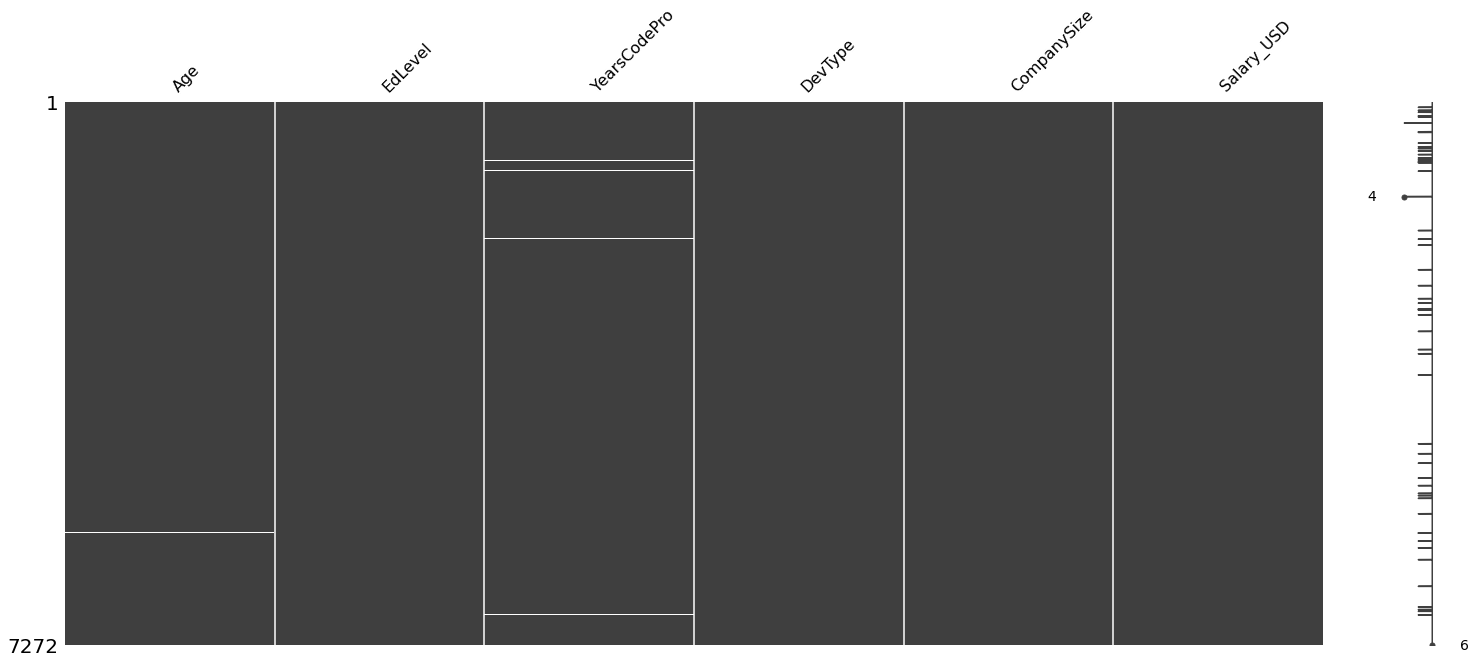

In [92]:
msno.matrix(data_df)

In [93]:
data_df = data_df.dropna()
data_df.shape[0]

7218

### Save cleaned dataset for future analysis

In [94]:
data_df.to_csv('/Users/tinglu/Desktop/stack-overflow-survey/Final_data.csv', index=False)